In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, scipy as sci, csv
from numpy import exp, pi, sinc, sin, tan, convolve, square, abs, arcsin, arctan, sqrt, cos, shape, array, mean
from scipy.signal import unit_impulse as dirac, find_peaks
period='holder'

9.999999999999999e-06
1.245e-06


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in arcsin


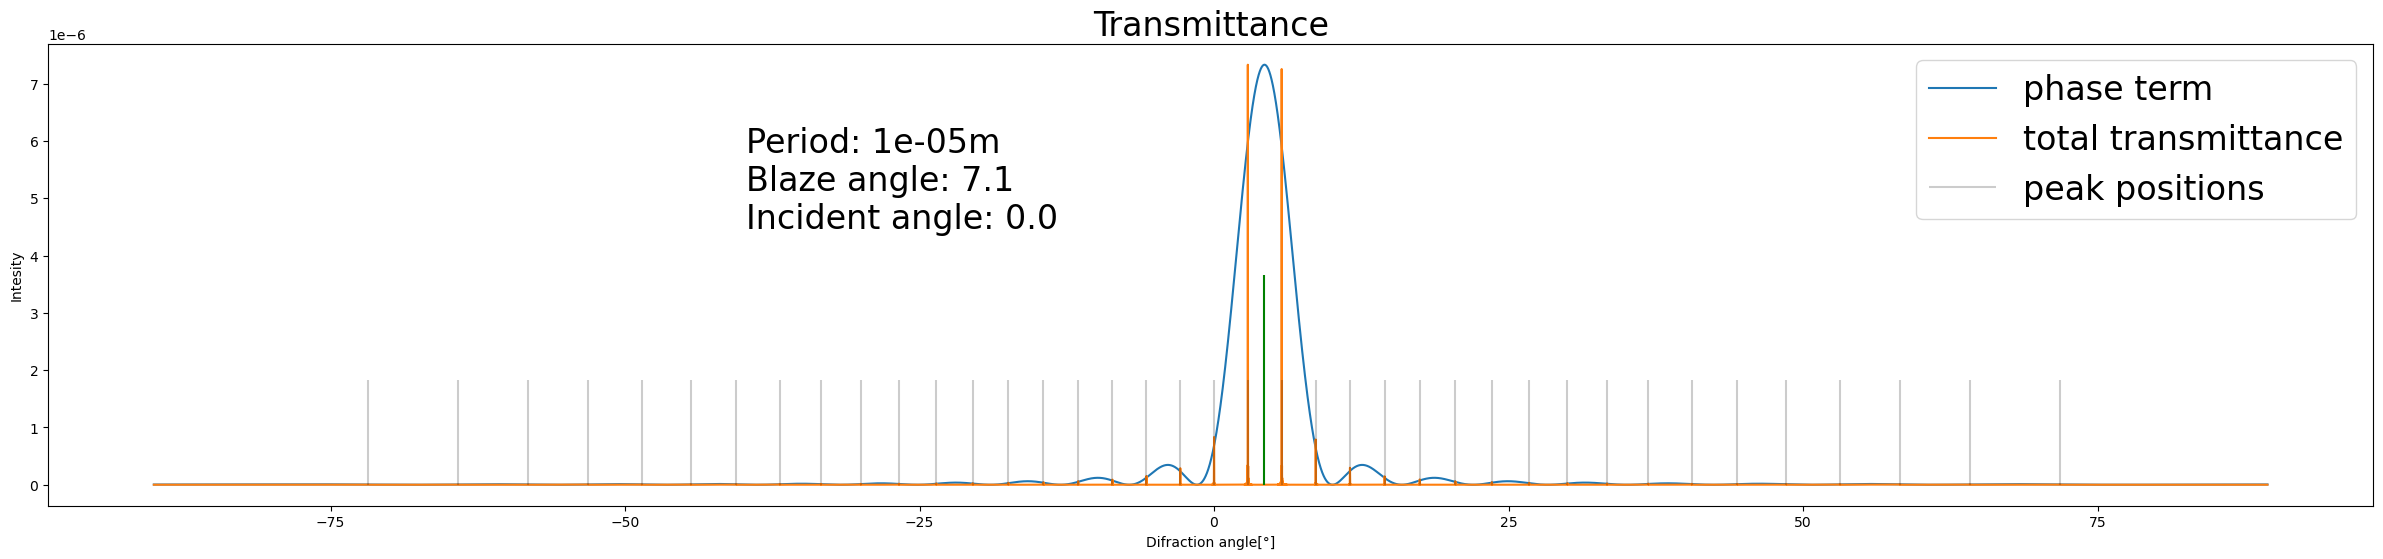

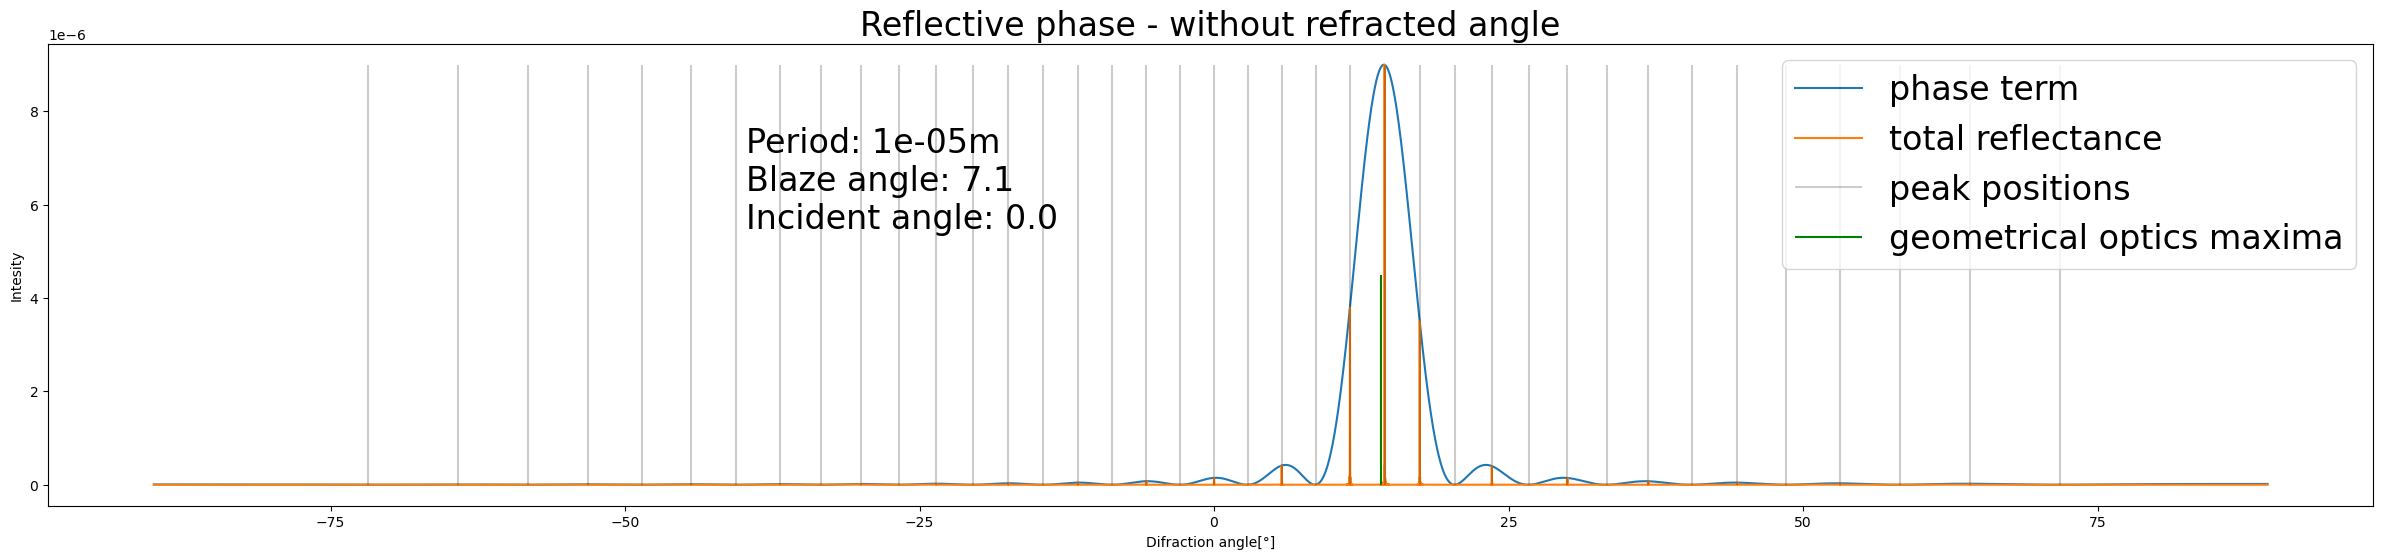

8e-06
1.049e-06


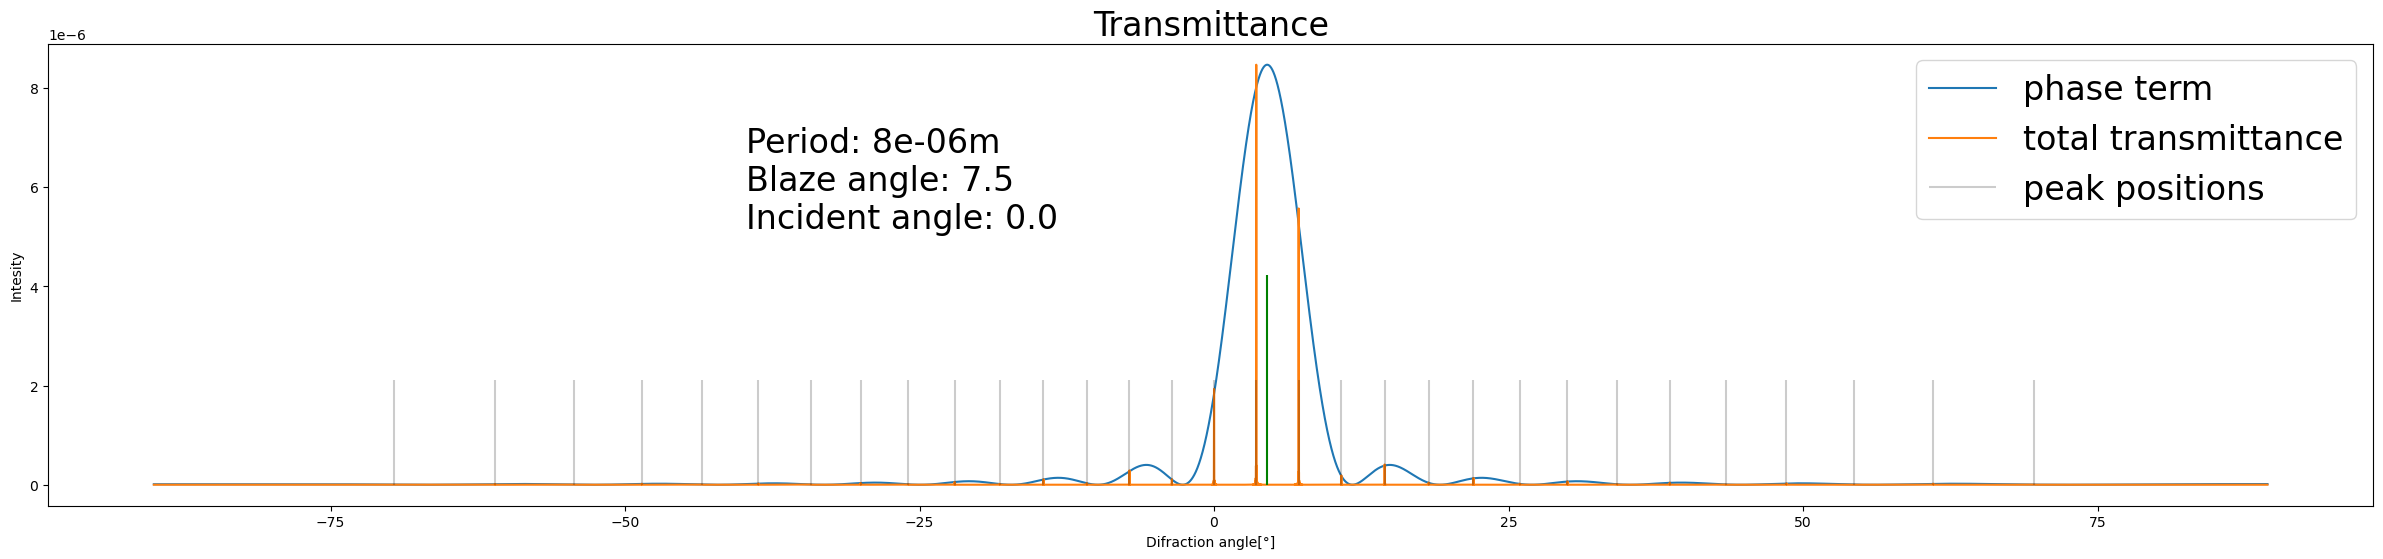

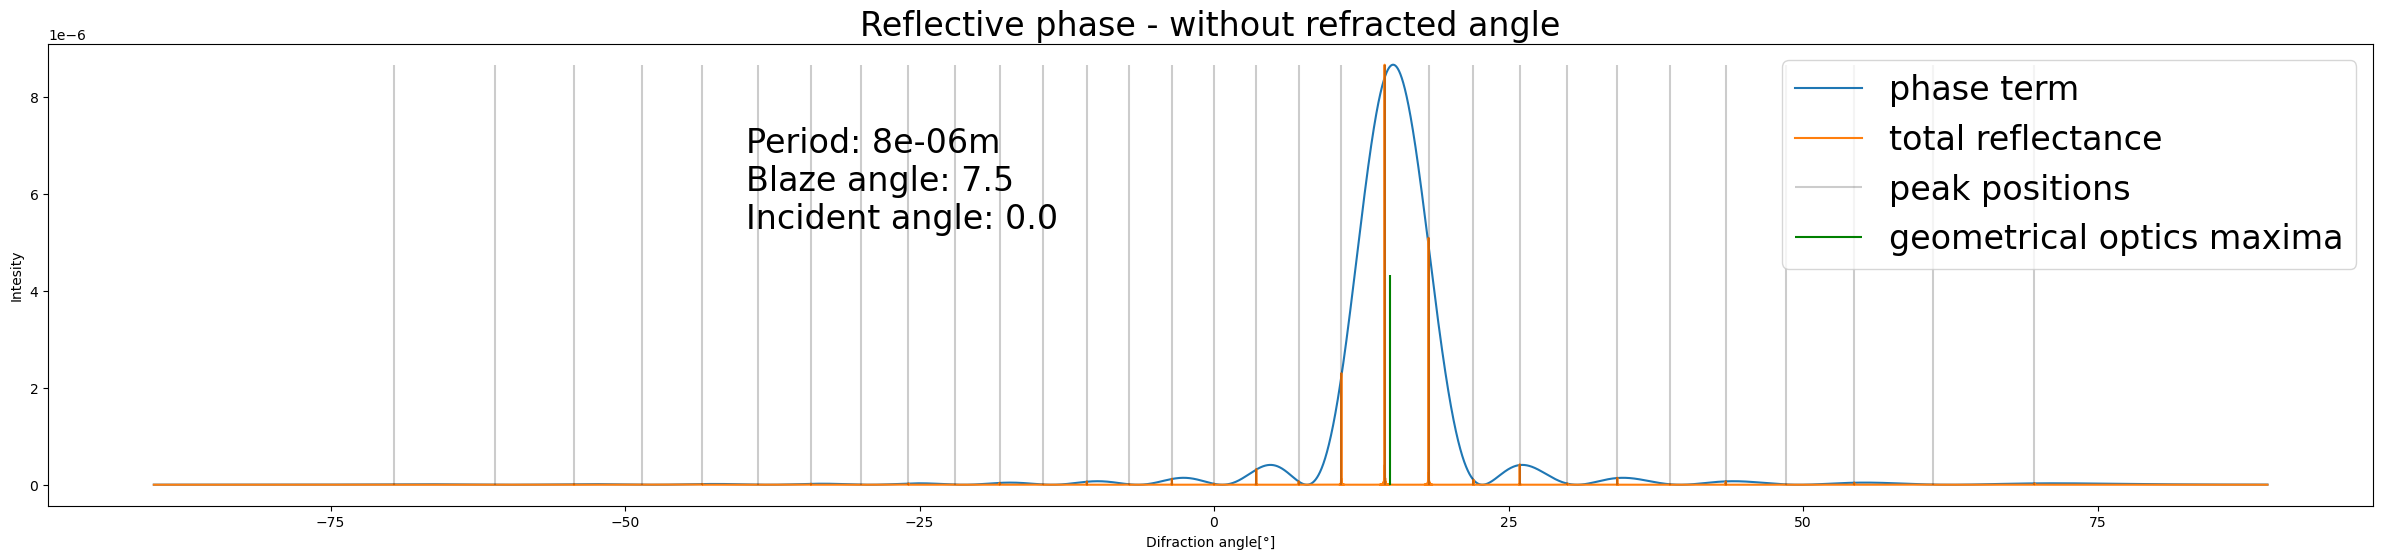

6e-06
8.53e-07


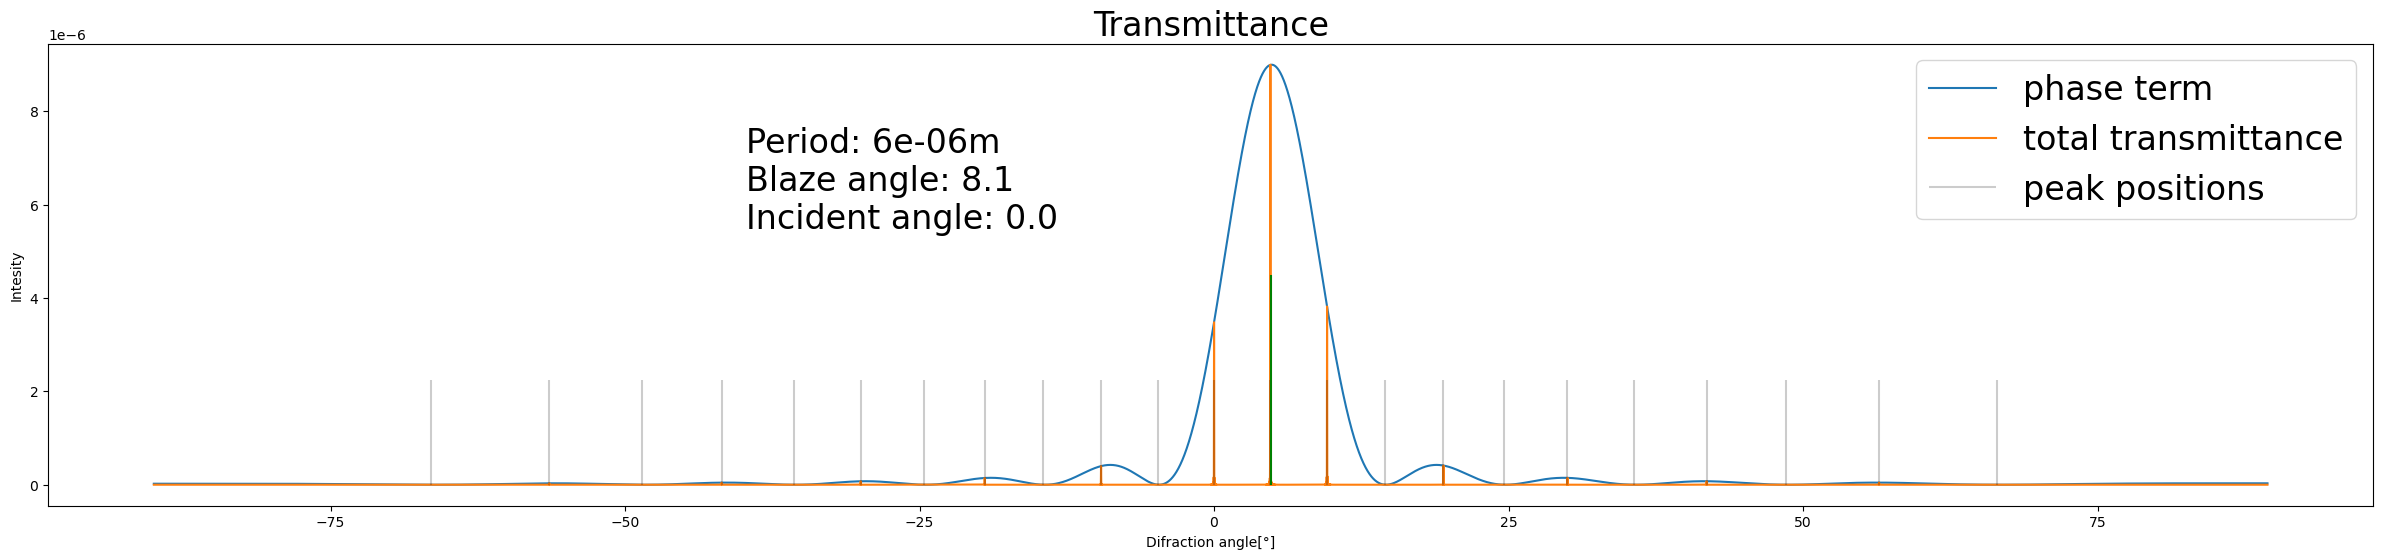

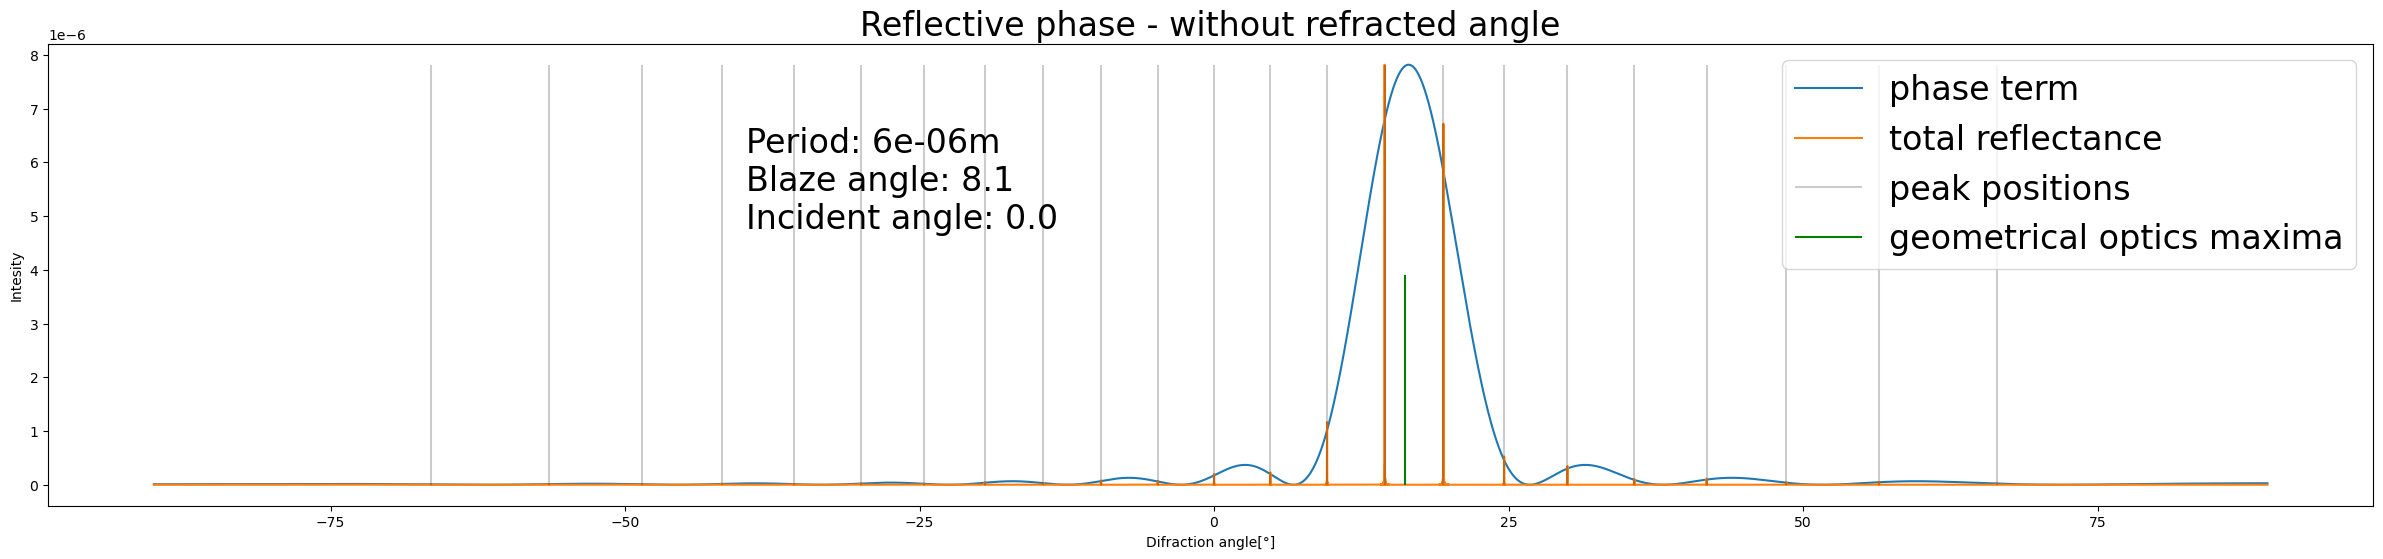

4e-06
6.57e-07


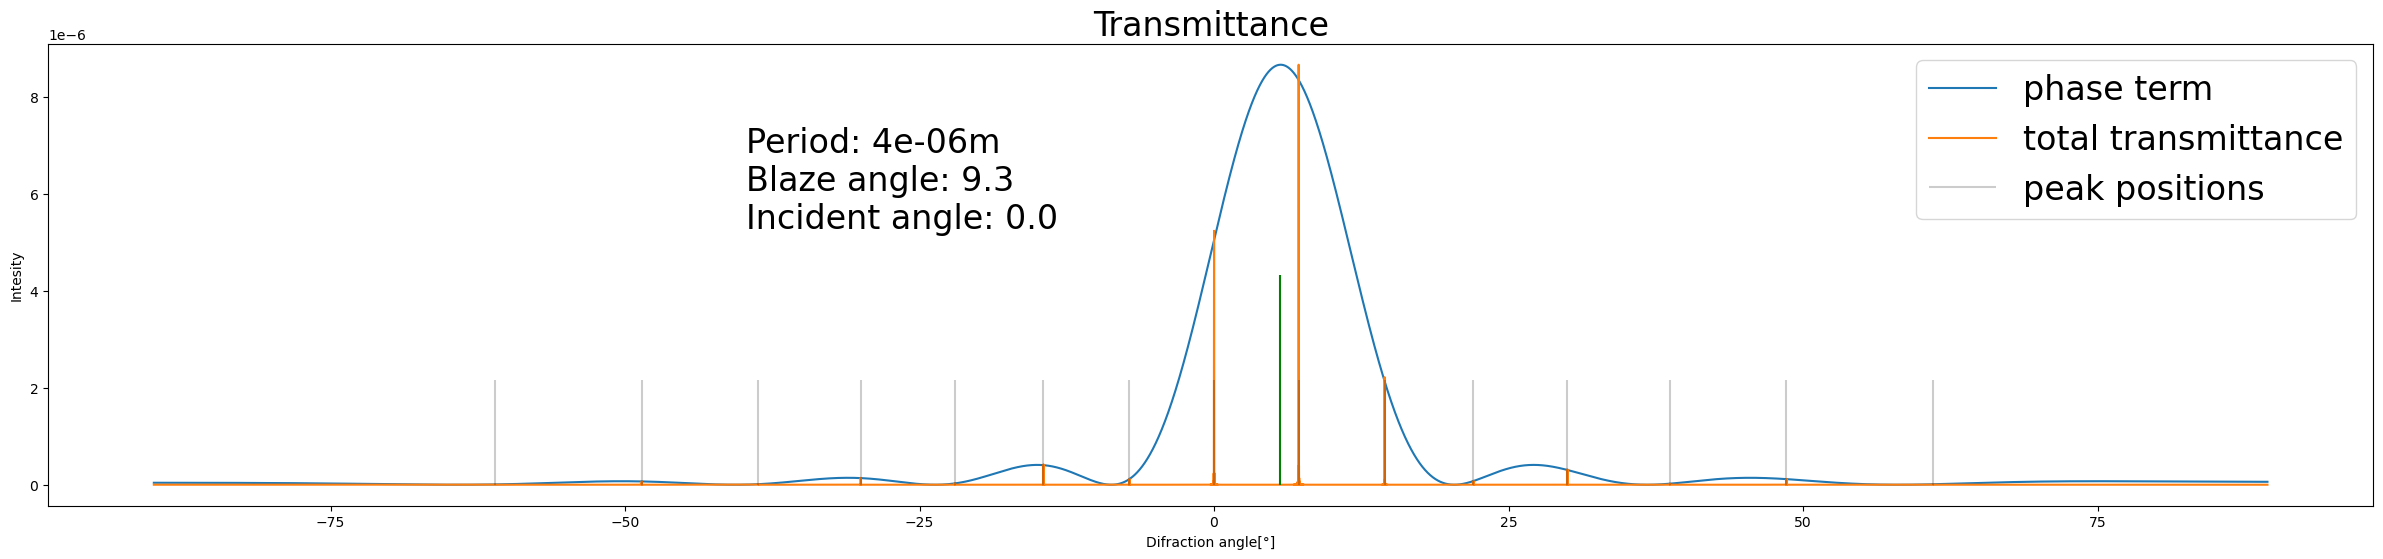

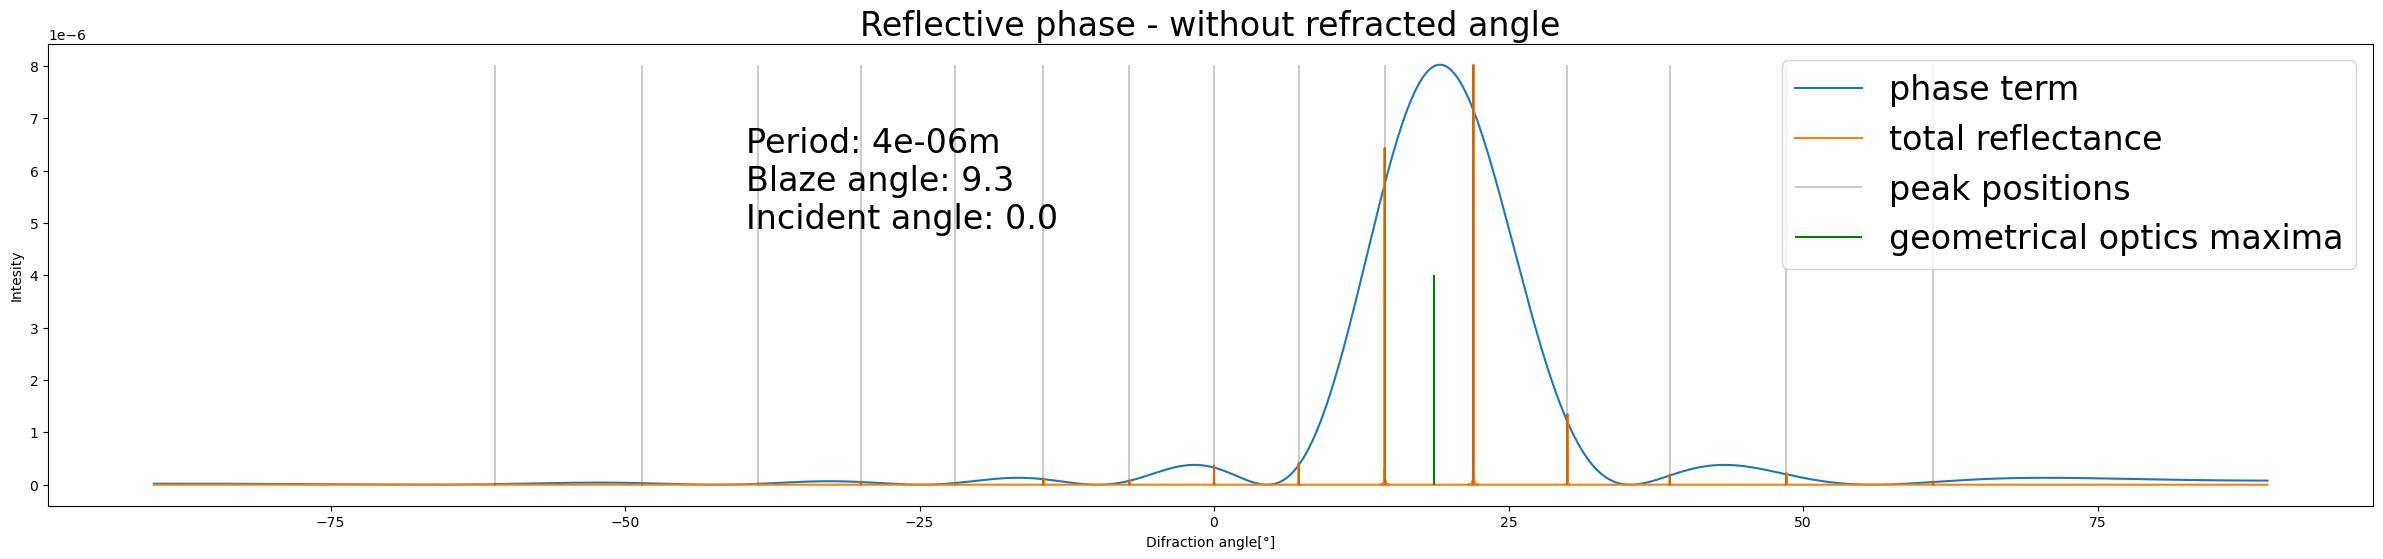

3e-06
5.590000000000001e-07


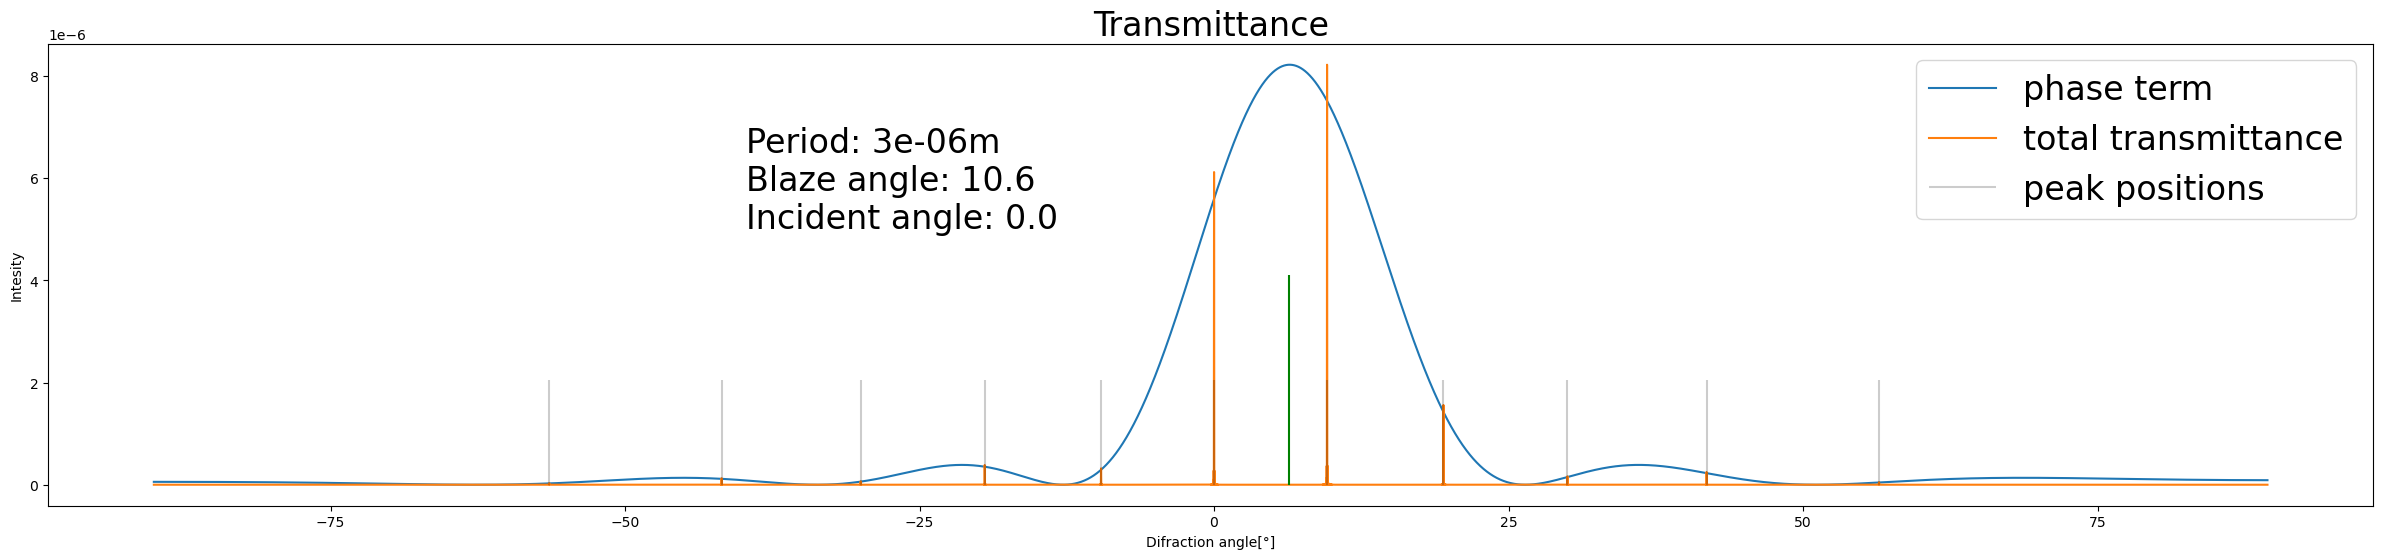

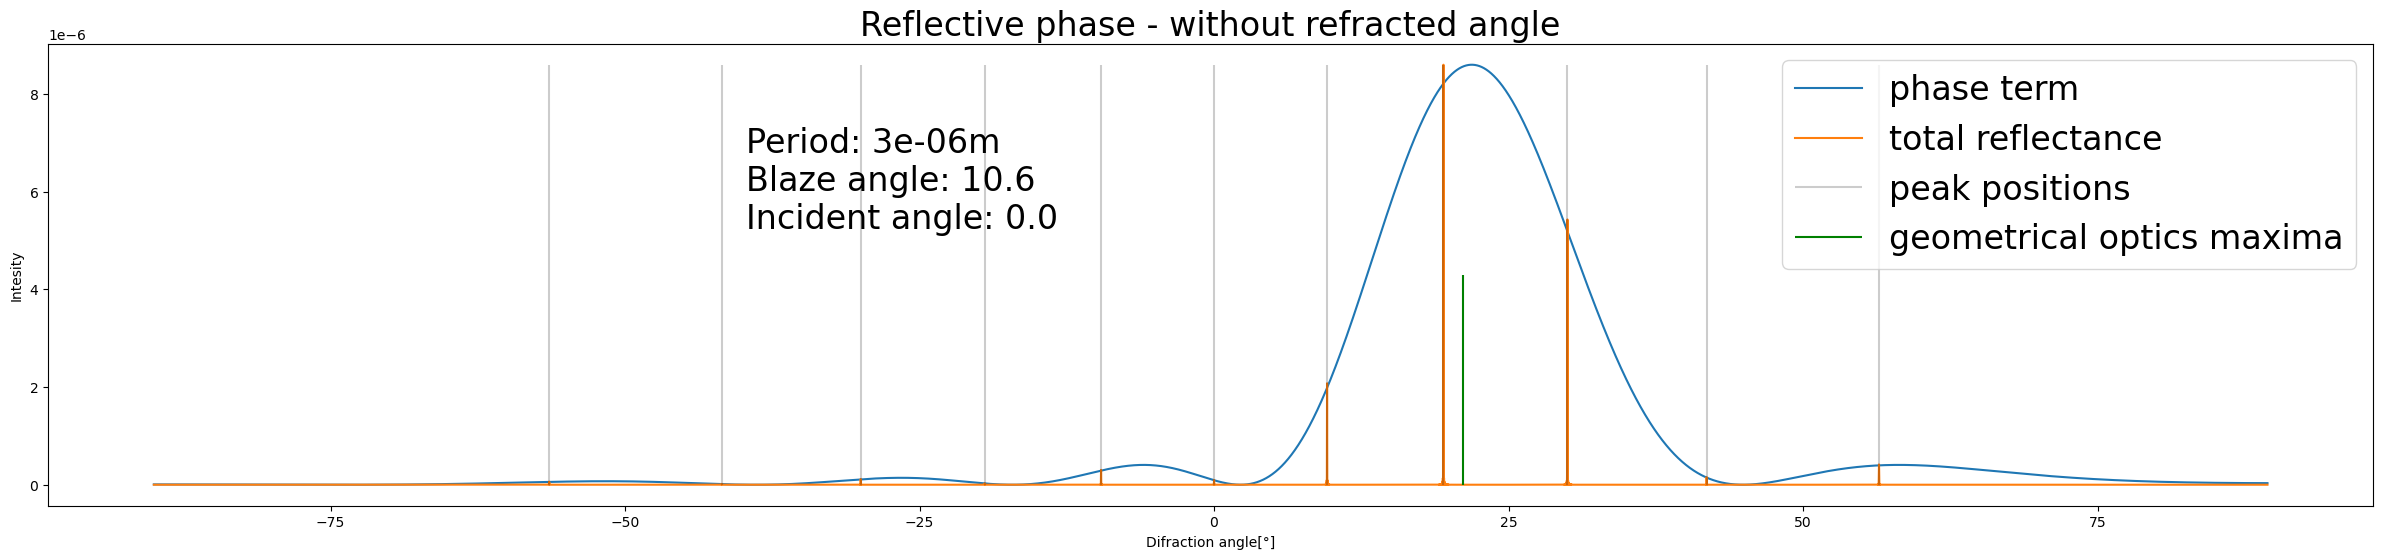

2e-06
4.6099999999999996e-07


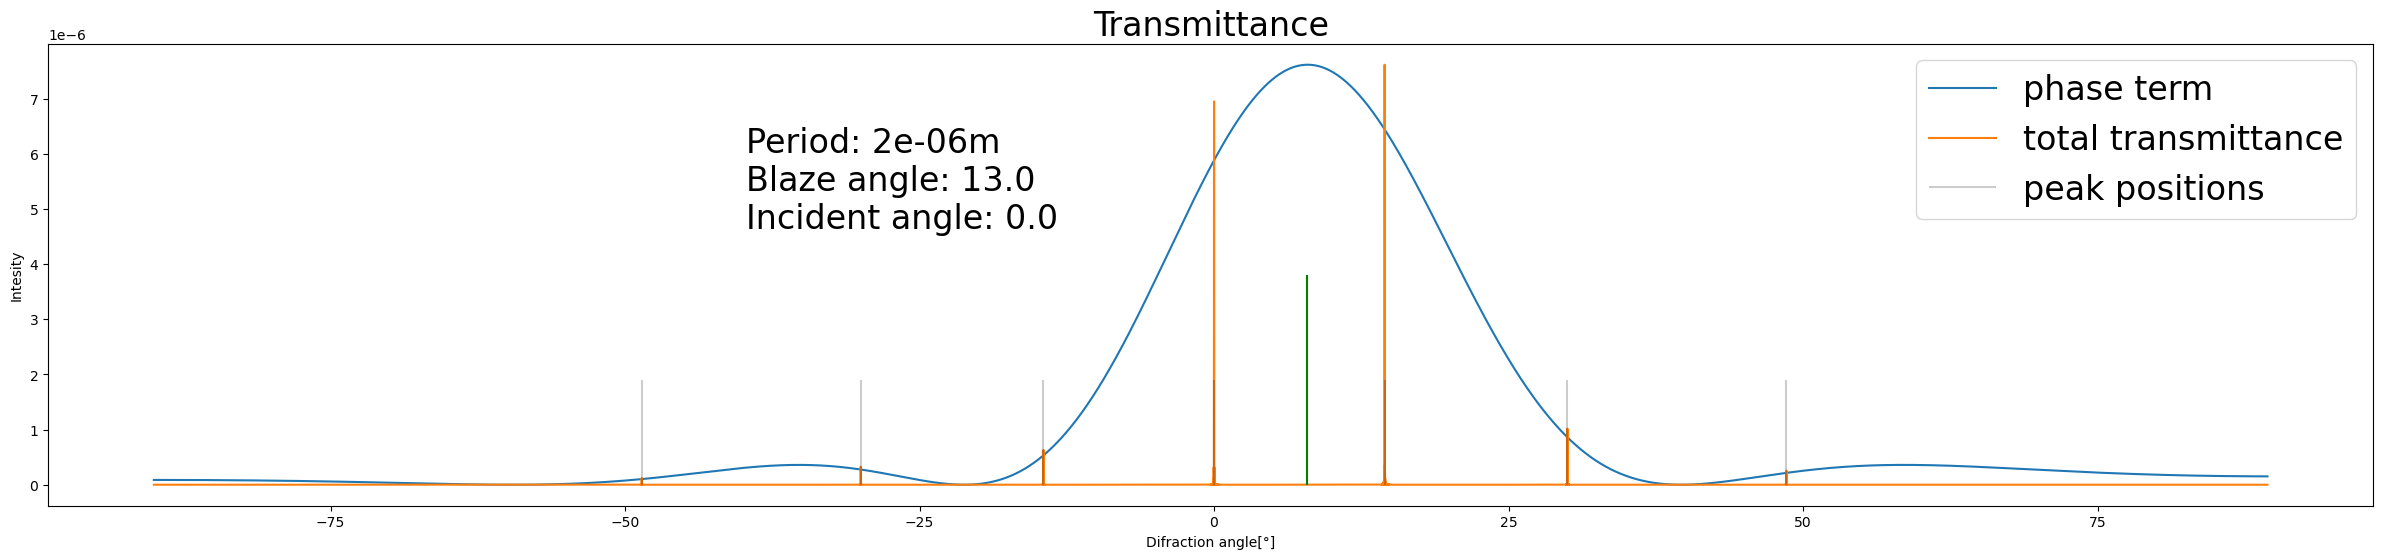

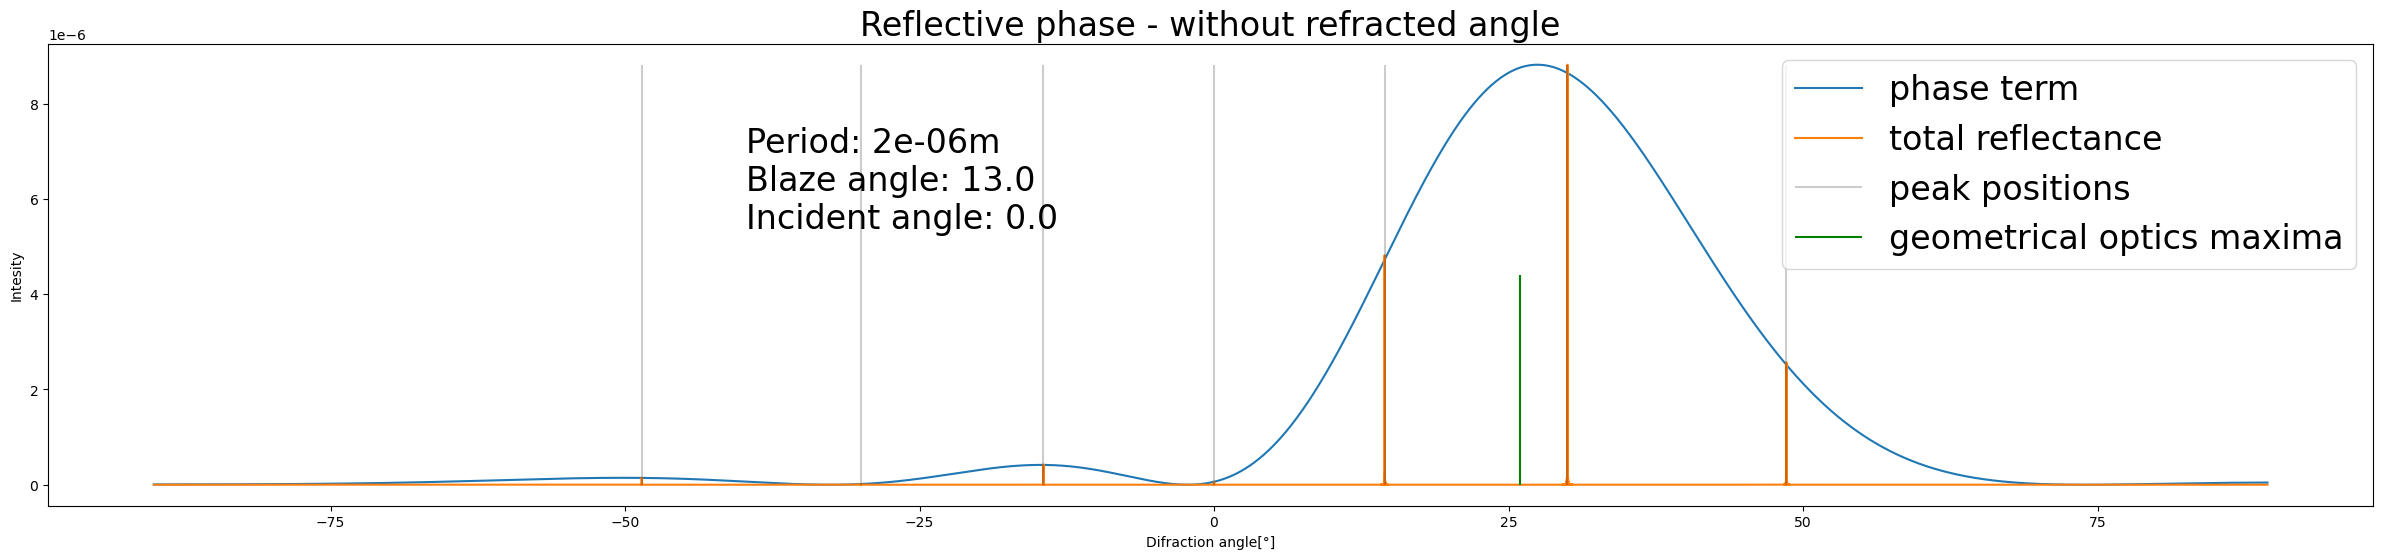

1.5e-06
4.12e-07


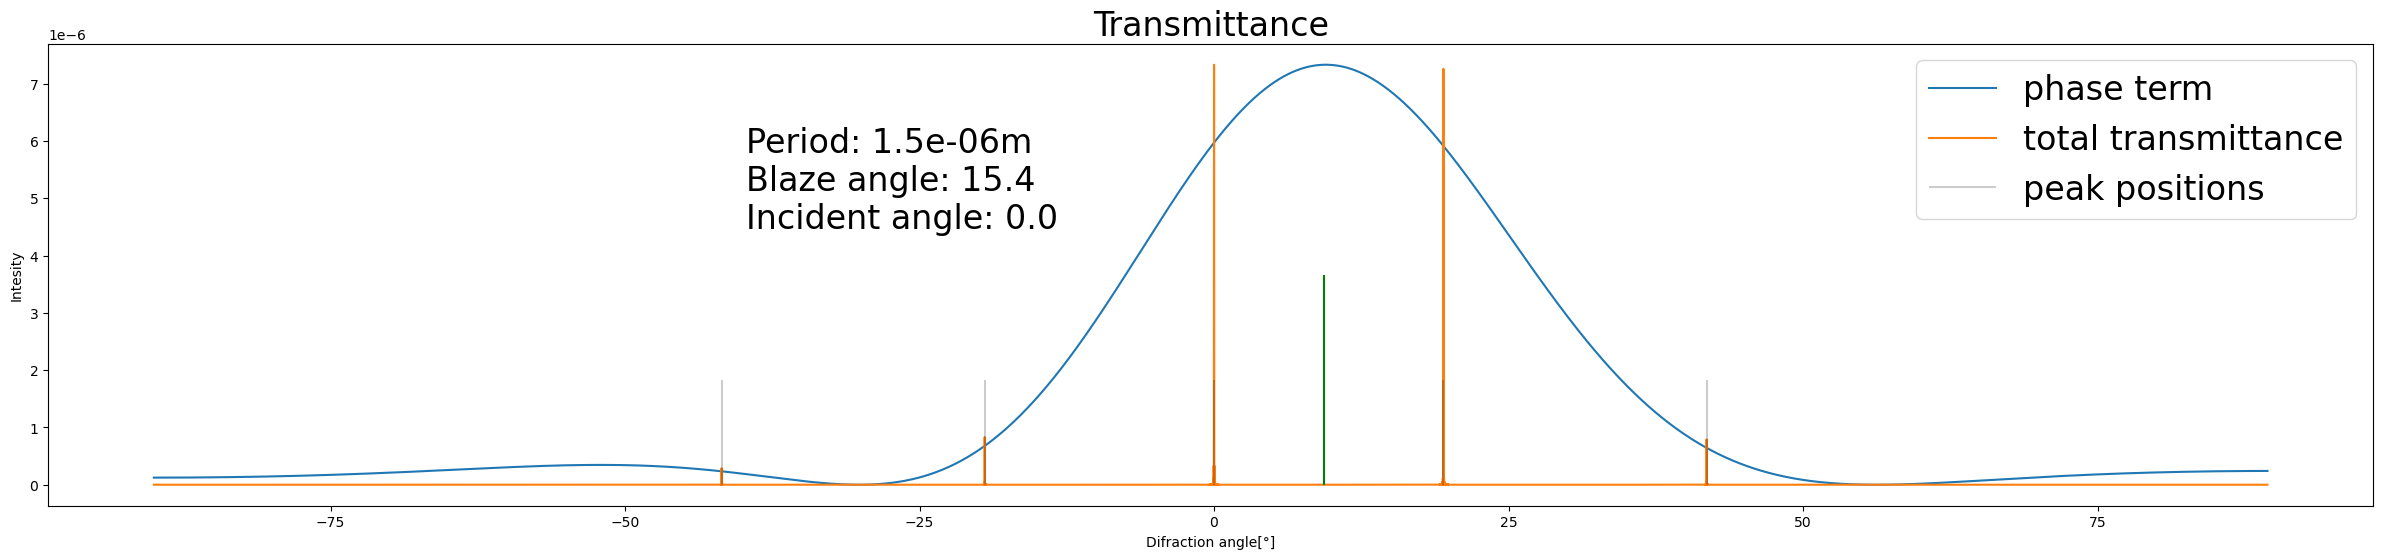

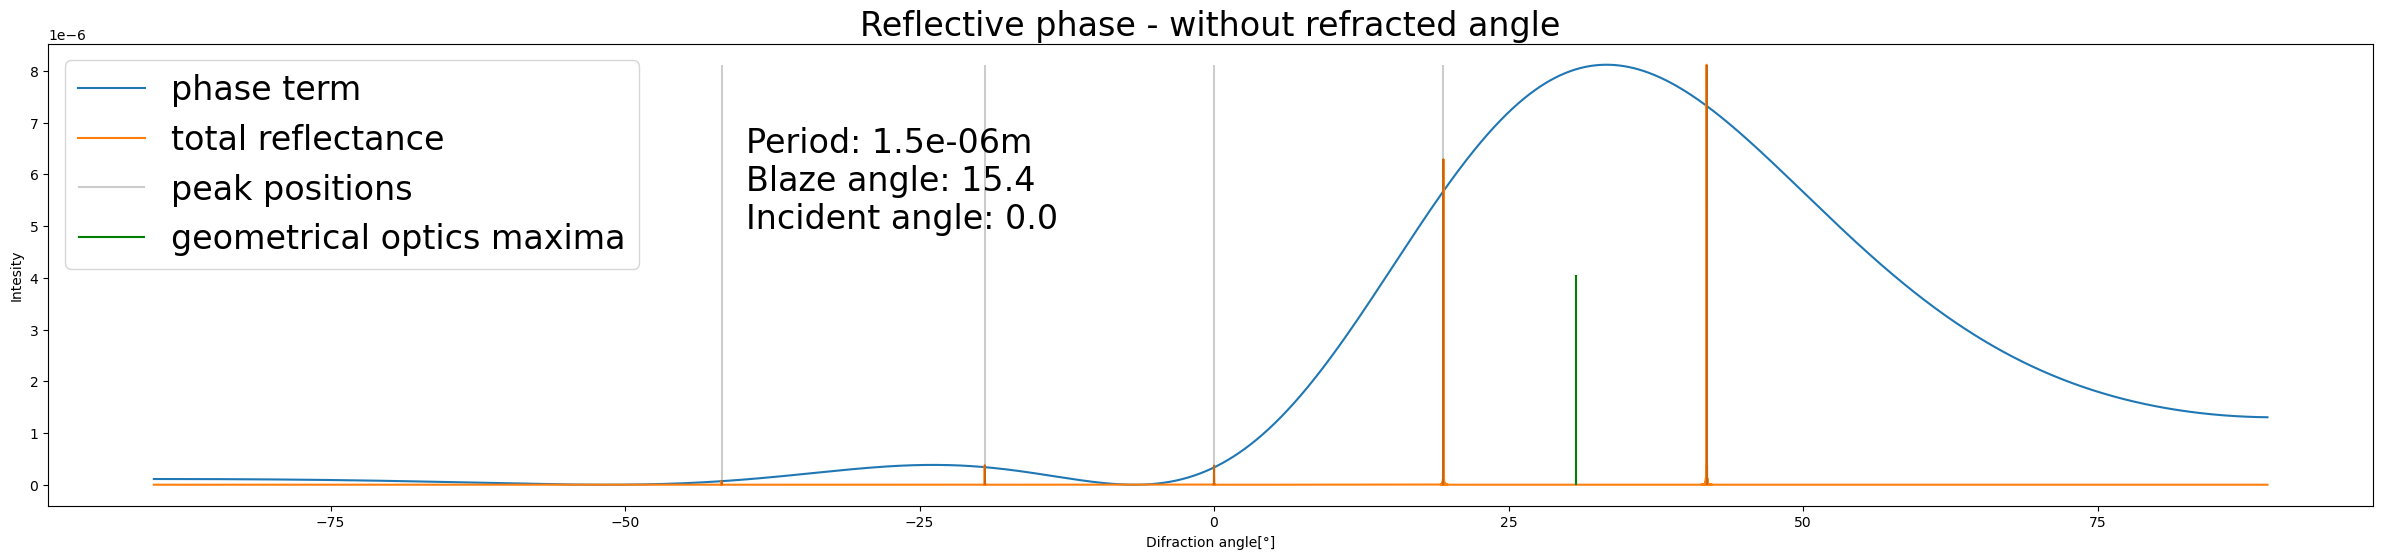

1e-06
3.63e-07


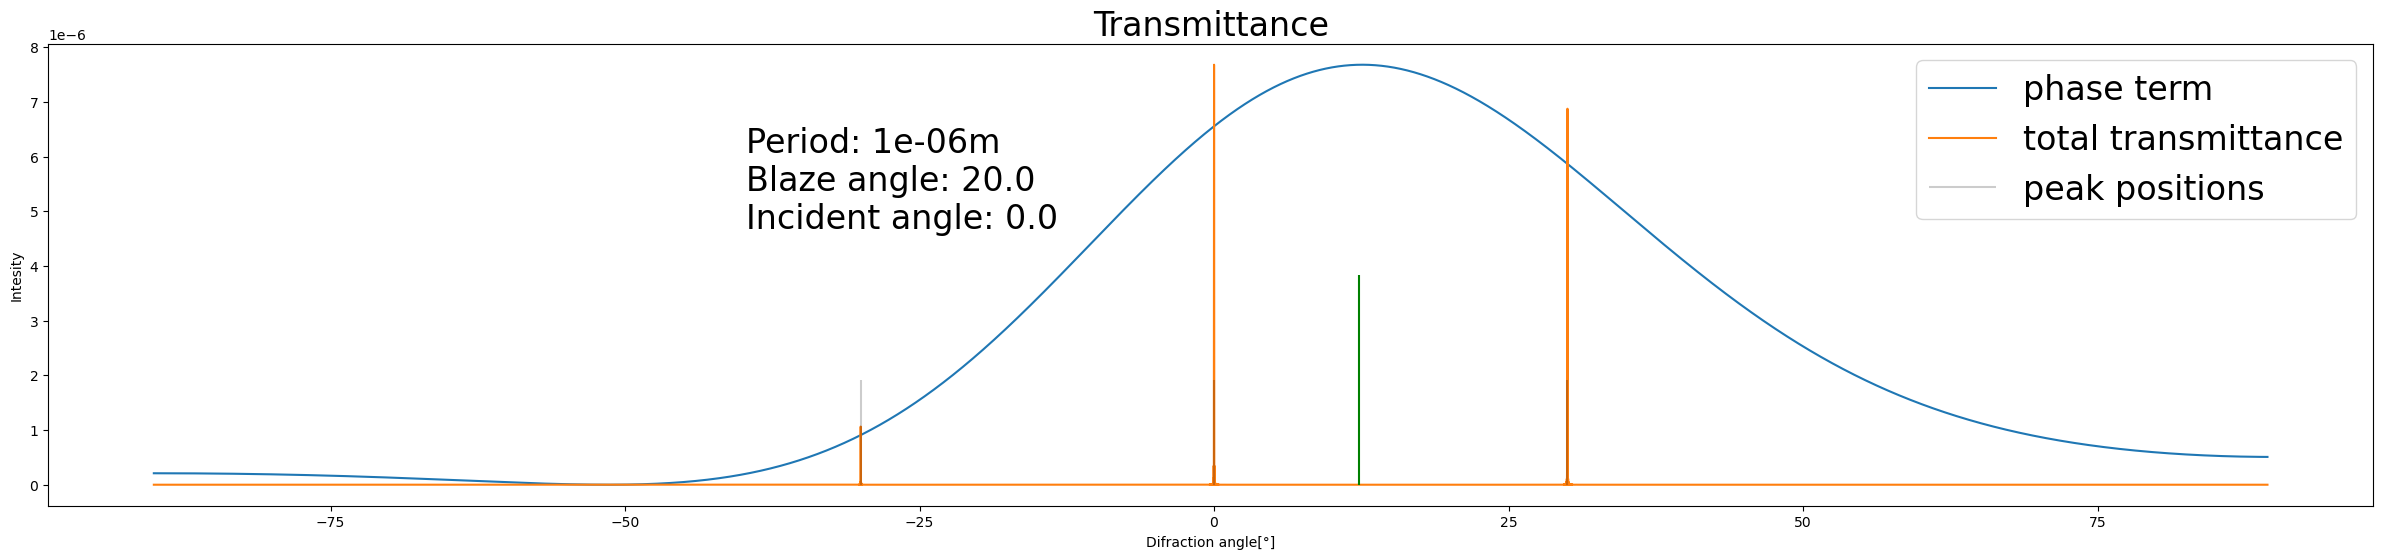

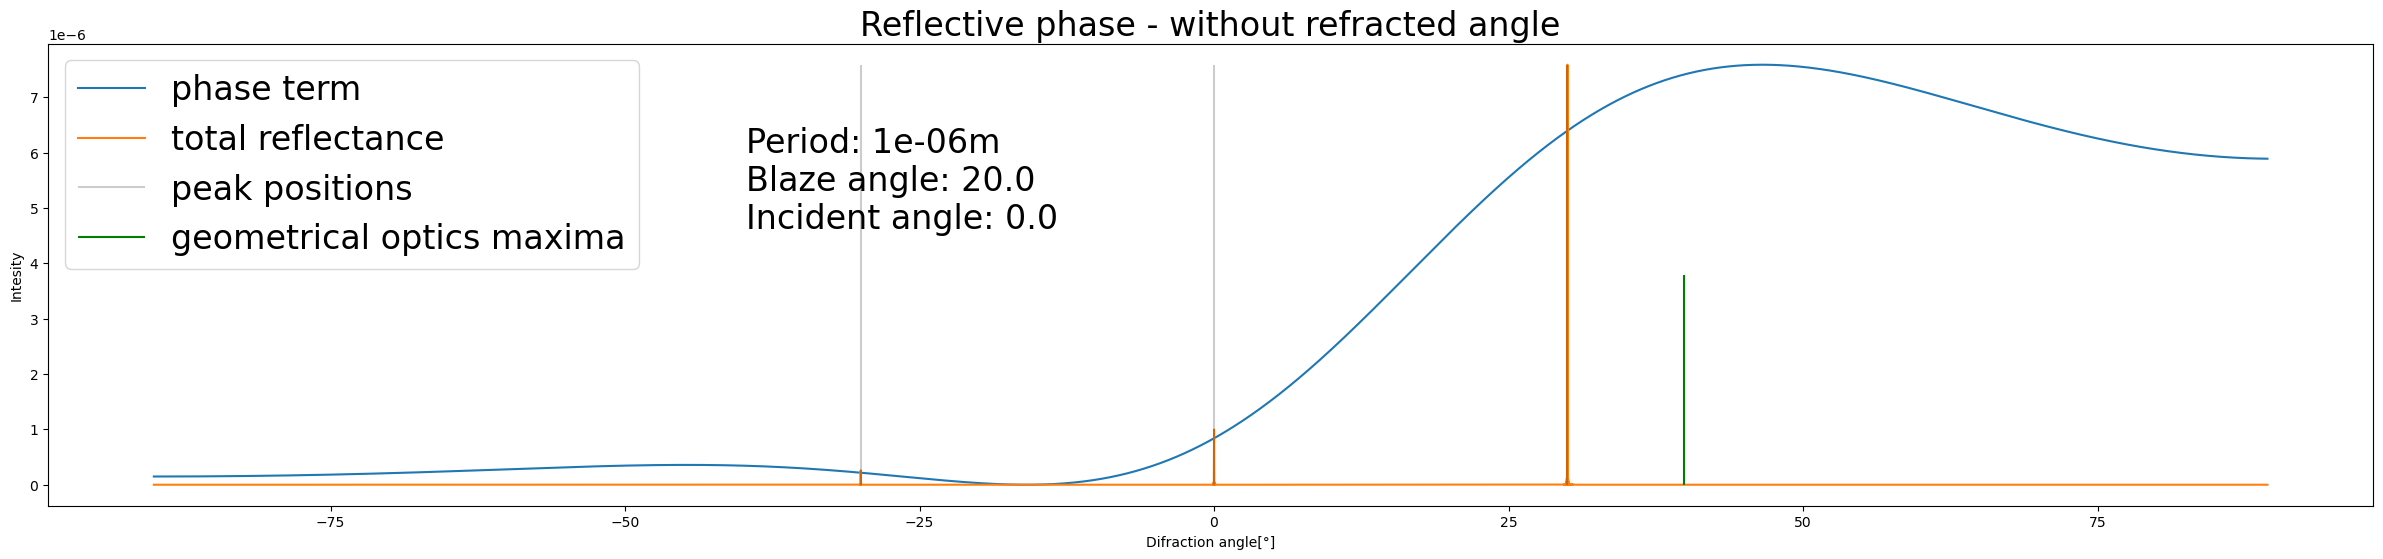

In [2]:
class Diffraction_pattern:
    def __init__(self, lamda, height, inc_angle, periods):
        self.lamda = lamda
        self.height = height
        self.inc_angle = inc_angle/180*pi
        self.frequency = np.arange(sin(-90/180*pi)/self.lamda,sin(90/180*pi)/self.lamda,100)
        self.blaze_angle = None
        self.angles_rad = arcsin(self.frequency*self.lamda)#[arcsin(x) for x in self.frequency*self.lamda]
        self.angles_deg = self.angles_rad/pi*180 #[angle_rad/pi*180 for angle_rad in self.angles_rad]
        self.periods = periods
        self.tick_height = 0
        self.length = 3000*1e-6 # size of the irradiated part of the grating in nanometers
        self.n = 1.6
        for T in periods:
            self.period = T*1e-6
            print(self.period)
            self.height = (98*self.period + 265*1e-6)/1000
            print(self.height)
            self.transmissive()
            self.reflective()
        
        
    def sha(self):    # operational
        pulse, _ = np.array(find_peaks(-np.abs(sin((self.frequency)*2*pi/(2/self.period))), distance= 200))
        comb = np.zeros(len(self.frequency - sin(self.inc_angle)/self.lamda))
        comb[pulse] = 1
        return 1/self.period * comb
    
    def pulses(self):
        pulse = np.zeros(len(self.frequency - sin(self.inc_angle)/self.lamda))
        print(pulse)
        peaks = self.angles_deg[pulse]
        pulse = peaks[np.where(peaks!=0)]
        print(pulse)
        
    def aperture(self):
        return self.length * sinc(self.frequency*self.length/2)
    
    def Rphasebox(self):
        irradiated = cos(self.inc_angle)/cos(self.blaze_angle-self.inc_angle) #* pi*self.period
        offset = irradiated*(sin(self.inc_angle - self.blaze_angle) + sin(- self.blaze_angle))/self.lamda
        return self.period * sinc((self.frequency + offset)*self.period/2)
    
    def Rphasebox_wave(self):
        irradiated = cos(self.inc_angle)/cos(self.blaze_angle-self.inc_angle) #* pi*self.period
        offset = irradiated*(sin(self.inc_angle - self.blaze_angle) + sin(self.angles_rad - self.blaze_angle))/self.lamda
        return self.period * sinc((self.frequency - offset)*self.period/2)
    
    def Tphasebox_complicated(self):
        irradiated = cos(self.inc_angle)/cos(self.blaze_angle-self.inc_angle)
        incoming = irradiated*(sin(self.inc_angle - self.blaze_angle))
        through = tan(self.blaze_angle)/cos(self.blaze_angle - arcsin(sin(self.inc_angle + self.blaze_angle)/self.n))
        out = sin(arcsin(sin(self.inc_angle+self.blaze_angle)/self.n)+self.blaze_angle)
        offset = (incoming - through)/self.lamda
        return self.period * sinc((self.frequency + offset)*self.period/2) #* #exp(-1j*2*pi/self.lamda*tan(self.blaze_angle)*self.period)
        
    def Tphasebox(self):
        offset = (- tan(self.blaze_angle) + self.n*tan(self.blaze_angle) + sin(self.inc_angle))/self.lamda
        return self.period * sinc((self.frequency - offset)*self.period/2)
    
    def Rmax(self):
        ref_angle = -self.inc_angle + 2*self.blaze_angle
        ref_angle = ref_angle*180/pi
        return ref_angle
    
    def Tmax(self):
        trans_angle = arcsin(self.n*sin(self.blaze_angle - arcsin(sin(self.inc_angle+self.blaze_angle)/self.n)))
        trans_angle = trans_angle*180/pi
        return trans_angle
                        
    def Rtotal(self):
        result = convolve(self.Rphasebox() * self.sha(), self.aperture(), mode = 'same')
        return result

    def Ttotal(self):
        result = convolve(self.Tphasebox() * self.sha(), self.aperture(), mode = 'same')
        return result
    
    def peaks(self):   # operational
        peaks = [arcsin(sin(self.inc_angle) - m*self.lamda/self.period) for m in range(-30,30)]
        return [peak/pi*180 for peak in peaks if abs(peak)<1.5]
    
    def transmissive(self, show_orders = True, show_max = True):
            self.blaze_angle = arctan(self.height/self.period)
            y = square(abs(self.Tphasebox()))
            y_total = square(abs(self.Ttotal()))
            y_complicated = square(abs(self.Tphasebox_complicated()))
            self.tick_height = max(y_total)/2
            peaks = self.peaks()
            maxima = self.Tmax()
            
            fig = plt.figure(figsize=(30,6))
            ax = fig.add_subplot(1, 1, 1)
            plt.title("Transmittance", fontsize = 24)
            plt.text(0.3, 0.6, 'Period: '+str(round(self.period,8))+'m \nBlaze angle: '+str(round(self.blaze_angle/pi*180,1))+' \nIncident angle: '+str(round(self.inc_angle/pi*180,1)),transform = ax.transAxes, fontsize =24)
            plt.xlabel('Difraction angle[°]')
            plt.ylabel('Intesity')
            plt.plot(self.angles_deg, y/max(y)*max(y_total), label = 'phase term')
            plt.plot(self.angles_deg, y_total, label = 'total transmittance')
            if show_orders: plt.vlines(peaks, np.zeros(len(peaks)), np.full(len(peaks),self.tick_height/2), color = 'black', alpha = 0.2, label = 'peak positions')
            #print(peaks)
            if show_max: plt.vlines(maxima, 0, self.tick_height, color = 'green')
            plt.legend(fontsize=24)
            plt.show()
            #self.pulses()
            
    def reflective(self, show_orders = True, show_max = True):
            self.blaze_angle = arctan(self.height/self.period)
            y = square(abs(self.Rphasebox()))
            y_wave = square(abs(self.Rphasebox_wave()))
            y_total = square(abs(self.Rtotal()))
            self.tick_height = max(y_total)/2
            peaks = self.peaks()
            maxima = self.Rmax()
            
            fig = plt.figure(figsize=(30,6))
            ax = fig.add_subplot(1, 1, 1)
            plt.title("Reflective phase - without refracted angle", fontsize = 24)
            plt.text(0.3, 0.6, 'Period: '+str(round(self.period,8))+'m \nBlaze angle: '+str(round(self.blaze_angle/pi*180,1))+' \nIncident angle: '+str(round(self.inc_angle/pi*180,1)),transform = ax.transAxes, fontsize =24)
            plt.xlabel('Difraction angle[°]')
            plt.ylabel('Intesity')
            plt.plot(self.angles_deg, y/max(y)*max(y_total), label = 'phase term')
            plt.plot(self.angles_deg, y_total, label = 'total reflectance')
            if show_orders: plt.vlines(peaks, np.zeros(len(peaks)), np.full(len(peaks),self.tick_height*2), color = 'black', alpha = 0.2, label = 'peak positions')
            if show_max: plt.vlines(maxima, 0, self.tick_height, color = 'green', label = 'geometrical optics maxima')
            plt.legend(fontsize=24)
            plt.show()
    
dif = Diffraction_pattern(lamda = 0.5e-6, height = [(98*x + 265)*1e-9 for x in [10,8,6,4,3,2,1.5,1]], inc_angle = 0, periods = [10,8,6,4,3,2,1.5,1])